# Gym Member Churn Prediction Model

This notebook builds a machine learning model to predict which gym members are at risk of cancelling their membership.

**Approach:**
1. Load user information and visit data
2. Engineer features from visit patterns (frequency, recency, trends)
3. Combine with user demographics
4. Train a classification model
5. Analyze feature importance to understand churn drivers


In [1]:
# Imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Add project root to path for imports
sys.path.insert(0, str(Path.cwd().parent))

# Feature engineering from auxiliar module
from auxiliar.auxiliar import engineer_features

# Model functions from churn_model
from src.churn_model import (
    train_churn_model,
    evaluate_model,
    get_feature_importance,
    predict_churn_risk,
    save_model,
    FEATURE_COLUMNS
)

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load data
data_dir = Path.cwd().parent / 'data'

users_df = pd.read_csv(data_dir / 'user_information.csv', parse_dates=['REGISTRATION_DATE', 'MEMBERSHIP_END_DATE'])
visits_df = pd.read_csv(data_dir / 'user_visits.csv', parse_dates=['ENTRY_TIME', 'EXIT_TIME'])

print(f"Users: {len(users_df)}")
print(f"Visits: {len(visits_df)}")
print(f"\nUsers columns: {users_df.columns.tolist()}")
print(f"\nChurned: {users_df['MEMBERSHIP_END_DATE'].notna().sum()}")
print(f"Active: {users_df['MEMBERSHIP_END_DATE'].isna().sum()}")


Users: 300
Visits: 3903

Users columns: ['USER_ID', 'REGISTRATION_DATE', 'MEMBERSHIP_END_DATE', 'AGE', 'GENDER', 'ZUMBA', 'BODY_PUMP', 'PILATES', 'SPINNING']

Churned: 110
Active: 190


## Feature Engineering

We'll create features that capture user behavior patterns:
- **Visit frequency**: total visits, visits per month
- **Recency**: days since last visit
- **Session patterns**: average duration, preferred hours
- **Trends**: is visit frequency declining?
- **Demographics**: age, gender, class enrollments


In [3]:
# Create features
print("Engineering features...")
features_df = engineer_features(users_df, visits_df)
print(f"Features created: {features_df.shape}")
features_df.head()


Engineering features...
Features created: (300, 22)


,USER_ID,CHURNED,total_visits,visits_per_month,avg_session_duration_min,days_since_last_visit,avg_days_between_visits,std_days_between_visits,visits_last_30_days,visits_last_60_days,...,pct_weekend_visits,visit_frequency_trend,membership_duration_months,AGE,GENDER,ZUMBA,BODY_PUMP,PILATES,SPINNING,num_classes_enrolled
0,93810,1,20,20.000000,60.700000,4,0.842105,1.067872,20,20,...,0.300000,-0.333333,1.000000,62,0,0,0,0,1,1
1,24592,0,9,0.580645,76.666667,54,49.375000,58.216192,0,2,...,0.222222,-0.200000,15.500000,20,0,0,0,0,0,0
2,13278,1,11,1.586538,67.454545,4,14.900000,11.948501,1,5,...,0.090909,1.666667,6.933333,34,1,0,0,0,0,0
3,46048,1,11,2.972973,57.363636,11,7.700000,6.634087,5,7,...,0.181818,0.750000,3.700000,61,0,0,0,0,0,0
4,42098,0,5,0.316456,51.200000,34,81.250000,97.595680,0,1,...,0.800000,-0.750000,15.800000,62,1,0,0,0,0,0


## Train the Model

We'll use a Random Forest classifier - it handles non-linear relationships well and provides feature importance.


In [4]:
# Train the model using the churn_model module
model, X_test, y_test = train_churn_model(features_df)

print(f"Test set: {len(X_test)} samples")
print(f"Churn rate in test: {y_test.mean()*100:.1f}%")


Test set: 75 samples
Churn rate in test: 36.0%


In [5]:
# Evaluate the model
results = evaluate_model(model, X_test, y_test)

print("=== MODEL PERFORMANCE ===\n")
print(results['classification_report'])
print(f"\nROC-AUC Score: {results['roc_auc_score']:.3f}")


=== MODEL PERFORMANCE ===

              precision    recall  f1-score   support

      Active       0.76      0.85      0.80        48
     Churned       0.67      0.52      0.58        27

    accuracy                           0.73        75
   macro avg       0.71      0.69      0.69        75
weighted avg       0.73      0.73      0.72        75


ROC-AUC Score: 0.748


## Feature Importance

Understanding which features drive churn predictions helps identify at-risk users and design retention strategies.


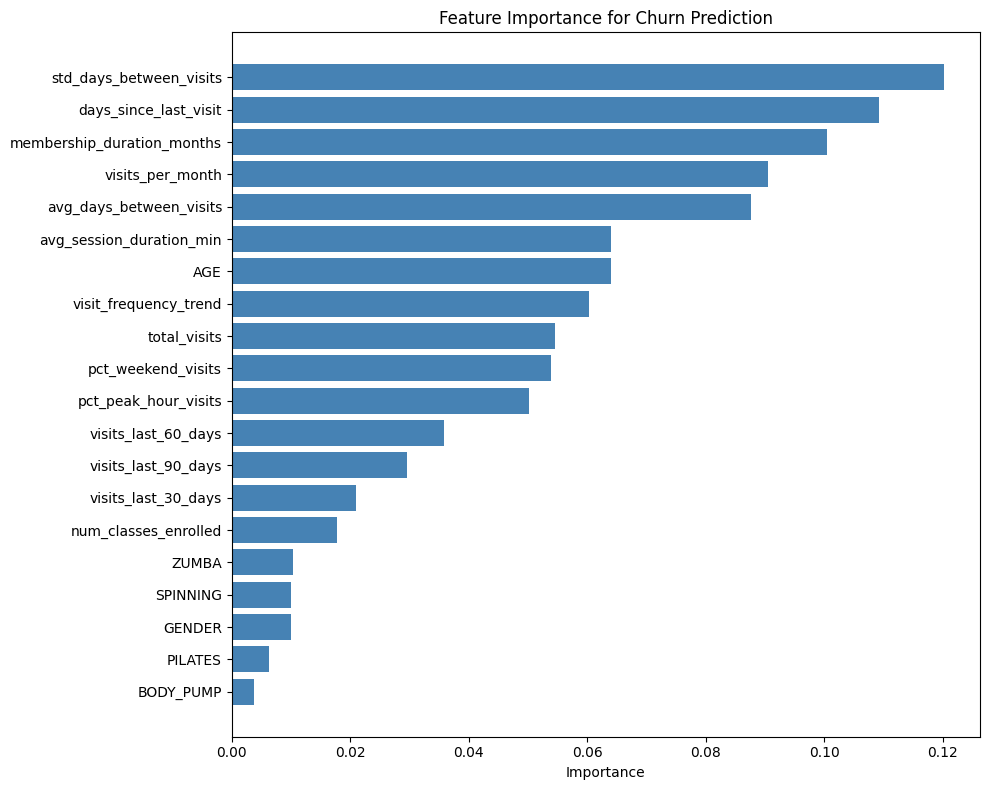


=== TOP 5 CHURN PREDICTORS ===
  std_days_between_visits: 0.120
  days_since_last_visit: 0.109
  membership_duration_months: 0.101
  visits_per_month: 0.091
  avg_days_between_visits: 0.088


In [6]:
# Feature importance
importance_df = get_feature_importance(model)

plt.figure(figsize=(10, 8))
importance_sorted = importance_df.sort_values('importance', ascending=True)
plt.barh(importance_sorted['feature'], importance_sorted['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Feature Importance for Churn Prediction')
plt.tight_layout()
plt.show()

print("\n=== TOP 5 CHURN PREDICTORS ===")
for _, row in importance_df.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")


## Churned vs Active Users Comparison

Let's compare the behavior patterns between users who churned and those who stayed.


In [7]:
# Compare key metrics between churned and active users
comparison_cols = ['visits_per_month', 'days_since_last_visit', 'avg_session_duration_min', 
                   'visit_frequency_trend', 'num_classes_enrolled']

churned = features_df[features_df['CHURNED'] == 1]
active = features_df[features_df['CHURNED'] == 0]

print("=== BEHAVIOR COMPARISON: CHURNED vs ACTIVE ===\n")
for col in comparison_cols:
    print(f"{col}:")
    print(f"  Churned: {churned[col].mean():.2f} (median: {churned[col].median():.2f})")
    print(f"  Active:  {active[col].mean():.2f} (median: {active[col].median():.2f})")
    print()


=== BEHAVIOR COMPARISON: CHURNED vs ACTIVE ===

visits_per_month:
  Churned: 3.34 (median: 1.46)
  Active:  1.27 (median: 0.57)

days_since_last_visit:
  Churned: 36.41 (median: 18.00)
  Active:  66.32 (median: 34.50)

avg_session_duration_min:
  Churned: 62.01 (median: 61.31)
  Active:  62.07 (median: 61.29)

visit_frequency_trend:
  Churned: 0.21 (median: 0.00)
  Active:  0.14 (median: 0.00)

num_classes_enrolled:
  Churned: 0.94 (median: 1.00)
  Active:  0.88 (median: 1.00)



## Identify At-Risk Active Users

Use the trained model to find currently active users who show similar patterns to those who churned.


In [8]:
# Predict churn risk for active users
risk_df = predict_churn_risk(model, features_df, active_only=True)

print("=== RISK DISTRIBUTION (Active Users) ===")
print(risk_df['risk_level'].value_counts())

print("\n=== TOP 10 AT-RISK USERS ===")
print(risk_df.head(10).to_string(index=False))


=== RISK DISTRIBUTION (Active Users) ===
risk_level
Low       154
Medium     33
High        3
Name: count, dtype: int64

=== TOP 10 AT-RISK USERS ===
 USER_ID  churn_risk risk_level
   96374    0.760250       High
   82132    0.717604       High
   69177    0.632464       High
   99192    0.547506     Medium
   37460    0.513152     Medium
   57819    0.510510     Medium
   60432    0.503142     Medium
   62565    0.486267     Medium
   93886    0.474213     Medium
   80381    0.466904     Medium


In [9]:
# Save the trained model for later use
model_path = Path.cwd().parent / 'output' / 'churn_model.joblib'
save_model(model, str(model_path))


Model saved to: c:\Users\polri\Desktop\Projectes\gym-member-retention-app\output\churn_model.joblib
